In [1]:
from get_data import get_data_train, get_data_val
from dataset_mrt import mrtDataset as Dataset
#import torch.nn.functional as F
import os

In [3]:
from get_data import get_data_train, get_data_val
from dataset_mrt import mrtDataset as Dataset
#import torch.nn.functional as F
import os

d ='/bigdata/hplsim/aipp/RLtract/deepFibreTracking/examples/data/HCP_extended/'
all_paths = [os.path.join(d, o) for o in os.listdir(d) 
                    if os.path.isdir(os.path.join(d,o))]
all_paths = [p + '/T1w/T1w_acpc_dc_restore_1.25.nii.gz' for p in all_paths]
all_paths_tup = []

import numpy as np
#loading of random indices such that training and validation data is the same for all runs
#have to be pre-saved one time
#only first 20 patients are taken
no_patients = 20
for p in all_paths[:no_patients]:
    all_paths_tup.append((p, '/home/ramana44/regularizedautoencoder-anwi_mrt_another_wass_epc3/val_indx/indx_'+(p.split("/"))[-3]+'.npy'))
    
from torch.utils.data import DataLoader
def get_loader(data, get_data, size, train_fl, batch_size=1):
    dataset = Dataset(data, get_data, train_fl)
    sampler = torch.utils.data.SubsetRandomSampler(list(range(size*no_patients)))
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=sampler, shuffle=False)
    return loader

from models import AE
import torch
#torch.set_default_tensor_type('torch.cuda.FloatTensor')
no_train_slices = 125
no_val_slices = 20
batch_size = 200
train_loader = get_loader(all_paths_tup, get_data_train, no_train_slices, True, batch_size)
test_loader = get_loader(all_paths_tup, get_data_val,no_val_slices, False, batch_size)

no_channels = 1
dx, dy = (train_loader.dataset.__getitem__(1).shape)

Total number of files in loader:  20
Total number of files in loader:  20


In [2]:
from get_data import get_data, get_data_train, get_data_val
import torch
import os
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from datasets import InMemDataLoader
import torch.nn.functional as F

ImportError: cannot import name 'get_data' from 'get_data' (/home/ramana44/regularizedautoencoder-anwi_mrt_another_wass_epc3/get_data.py)

## Loading datasets

In [2]:
d ='/bigdata/hplsim/aipp/RLtract/deepFibreTracking/examples/data/HCP_extended/'
all_paths = [os.path.join(d, o) for o in os.listdir(d) 
                    if os.path.isdir(os.path.join(d,o))]
all_paths = [p + '/T1w/T1w_acpc_dc_restore_1.25.nii.gz' for p in all_paths]


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
torch.cuda.is_available()

False

In [5]:
import nibabel as nib

def get_data(paths, device, shuffle=False):
    data = _normalize([_rotate(nib.load(p).get_fdata()) for p in paths])   # load and preprocess all slices from all patients                               
    data_t = torch.FloatTensor(data).to(device)                            # data_t has now the shape: (num_patients, x, y, num_slices)
    data_t = data_t.permute(0, 3, 1, 2)                                    # permute data_t to be in shape (num_patients, num_slices, x, y)
    data_t = data_t[:, :123, :, :]
    data_t = data_t.reshape(data_t.shape[0]*data_t.shape[1],               # reduce dim of data_t to have shape (num_patients*num_slices, x, y)
             data_t.shape[2], data_t.shape[3])
    data_t = data_t.unsqueeze(1)                                           # add image channel, data_t now has shape (num_patients*num_slices, num_channel, x, y)
    if shuffle:                                                            # randomly shuffle all slices
        random_indices = torch.randperm(data_t.shape[0])                   # get list of random indices 
        data_t = data_t[random_indices, :, :, :]                           # reorder the set with the random indices
    return data_t

def _normalize(data):
    data = (data - np.min(data))/(np.max(data)-np.min(data))                # normalize data
    return data                     

def _rotate(data):
    data = np.rot90(data)                                                   # rotate by 90°, without rotation the base of the skull is located to the left of the image       
    return data                                                             # with rotation, the base of the skull is located to the bottom of the image


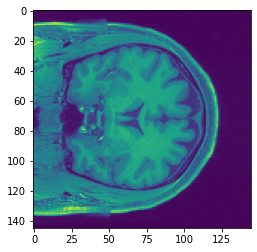

In [6]:
data = nib.load(all_paths[0]).get_fdata()
data = _normalize(_rotate(data))
plt.imshow(data[70])

In [7]:
set_ = get_data(all_paths, device)
print(set_.shape)
#plot_images(set_[103:123])
#plt.close()

torch.Size([9594, 1, 174, 145])


In [8]:
def get_train_test_set(paths, device, batch_size=32, train_set_size=0.2, test_set_size=0.2):
    assert train_set_size + test_set_size <= 1., "Train and test set size should not exceed 100%"
    
    path_indices = np.arange(len(paths))
    #np.random.shuffle(path_indices)                             # randomize indices of the paths for train and test set selection
    
    num_train = int(np.round_(len(paths) * train_set_size))     # calc amount of training sets to load
    num_test = int(np.round_(len(paths) * test_set_size))       # calc amount of test sets to load
    train_indices = path_indices[:num_train]                    # select unique and random indices from all paths
    test_indices = path_indices[-num_test:]   # for train and test set


    train_data = get_data([paths[i] for i in train_indices], device)  # only load specific indices preveiously selected
    test_data = get_data([paths[i] for i in test_indices], device)

    train_loader = InMemDataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True) # init dataloader for train and test set
    test_loader = InMemDataLoader(test_data, batch_size=batch_size, shuffle=True, drop_last=True) 
    return train_loader, test_loader

## Plotting for evaluation

In [17]:
from get_data import get_data_train, get_data_val
from dataset_mrt import mrtDataset as Dataset
#import torch.nn.functional as F
import os

d ='/bigdata/hplsim/aipp/RLtract/deepFibreTracking/examples/data/HCP_extended/'
all_paths = [os.path.join(d, o) for o in os.listdir(d) 
                    if os.path.isdir(os.path.join(d,o))]
all_paths = [p + '/T1w/T1w_acpc_dc_restore_1.25.nii.gz' for p in all_paths]
all_paths_tup = []

In [18]:
no_patients = 20
for p in all_paths[:no_patients]:
    all_paths_tup.append((p, '/home/ramana44/regularizedautoencoder-anwi_mrt_another_wass_epc4/val_indx/indx_'+(p.split("/"))[-3]+'.npy'))


In [19]:
from torch.utils.data import DataLoader
def get_loader(data, get_data, size, train_fl, batch_size=1):
    dataset = Dataset(data, get_data, train_fl)
    sampler = torch.utils.data.SubsetRandomSampler(list(range(size*no_patients)))
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=sampler, shuffle=False)
    return loader

In [20]:
no_train_slices = 125
no_val_slices = 20
batch_size = 200
train_loader = get_loader(all_paths_tup, get_data_train, no_train_slices, True, batch_size)
test_loader = get_loader(all_paths_tup, get_data_val,no_val_slices, False, batch_size)

Total number of files in loader:  20
Total number of files in loader:  20


In [22]:
# load trained rAE and bAE
from models import AE
path = '/home/ramana44/regularizedautoencoder-pia_mrt/output/MRT_full/test_run_saving/'
#specify hyperparameters
reg_nodes_sampling = 'legendre'
alpha = 0.0001
frac = 0.05
hidden_size = 1024
deg_poly = 10
latent_dim = 10
lr = 0.003
no_layers = 3

name = '_'+reg_nodes_sampling+'_'+str(frac)+'_'+str(alpha)+'_'+str(hidden_size)+'_'+str(deg_poly)+'_'+str(latent_dim)+'_'+str(lr)+'_'+str(no_layers)

no_channels = 1
dx, dy = (train_loader.dataset.__getitem__(1).shape)

#no_channels, dx, dy = (train_loader.dataset.__getitem__(1).shape)
inp_dim = [no_channels, dx, dy]
model_reg = AE(inp_dim, hidden_size, latent_dim, no_layers, F.relu).to(device)
model_base = AE(inp_dim, hidden_size, latent_dim, no_layers, F.relu).to(device)

#model_reg.load_state_dict(torch.load(path+'model_reg'+name, map_location=torch.device('cpu'))["model"])
#model_base.load_state_dict(torch.load(path+'model_reg'+name, map_location=torch.device('cpu'))["model"])

model_reg.load_state_dict(torch.load(path+'model_reg'+name, map_location=torch.device('cpu')))
model_base.load_state_dict(torch.load(path+'model_reg'+name, map_location=torch.device('cpu')))
#model_reg.eval()
#model_base.eval()

torch.Size([20, 25230])
torch.Size([20, 1, 174, 145])
torch.Size([1, 174, 145])
torch.Size([1, 174, 145])
torch.Size([174, 145])


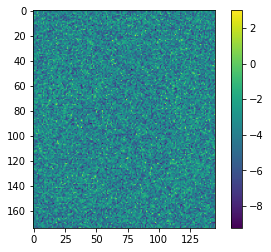

In [11]:
batch_val = next(iter(test_loader))[:20]

reconstruction_val = model_reg(next(iter(test_loader))[:20])
print(reconstruction_val.shape)
reconstruction_val = reconstruction_val.view(batch_val.shape)
print(reconstruction_val.shape)
print(reconstruction_val[0,:].shape)
print(reconstruction_val[0,:].reshape(1, 174, 145).shape)
print(reconstruction_val[0,:].reshape(1, 174, 145).squeeze(0).shape)
plt.imshow(reconstruction_val[1,:].reshape(1, 174, 145).squeeze(0).detach().cpu().numpy())
plt.colorbar()

In [12]:
def computeC1Loss(cheb_nodes, model, device, guidanceTerm = True):
    # extends C1 loss by guidance term
    noNodes, szLatDim = cheb_nodes.shape
    I = torch.eye(szLatDim).to(device) # extract values of all minor diagonals (I = 1) 
    f = lambda x: model.encoder(model.decoder(x.to(device))) # loop through autoencoder
    Jac = torch.autograd.functional.jacobian(f, cheb_nodes.to(device), create_graph = True)
    #Jac = Jac.unsqueeze(1).unsqueeze(3)
    #print("Shape Jacobian: ", Jac.shape)
    loss_C1_arr = torch.zeros(noNodes).to(device)
    inum = 0
    for i in range(cheb_nodes.shape[0]):
    #for node_points in cheb_nodes:
        #node_points = torch.reshape(node_points, (1, szLatDim))
        #Jac = torch.autograd.functional.jacobian(f, node_points.to(device), create_graph = True).squeeze() # compute Jacobian
        loss_C1 = torch.mean((Jac[i,:,i,:] - I)**2)
        if(guidanceTerm):
            min_diag_val = torch.mean((torch.diagonal(Jac[i,:,i,:], dim1 = 0, dim2 = 1) - 1)**2)
            loss_C1 = loss_C1 + min_diag_val
        loss_C1_arr[inum] = loss_C1
        inum += 1
        
    #calculate jacobian of all the nodes together    
    Jac = torch.autograd.functional.jacobian(f, cheb_nodes.to(device), create_graph = True).squeeze() # compute Jacobian
    return torch.mean(loss_C1_arr), Jac

In [13]:
Jac_val_pts = torch.FloatTensor(  np.random.uniform(-1,1,size=(4, latent_dim))   ).to(device)
noNodes, szLatDim = Jac_val_pts.shape
I = torch.eye(szLatDim).to(device) # extract values of all minor diagonals (I = 1)
print(I.shape)
f = lambda x: model_reg.encoder(model_reg.decoder(x.to(device))) # loop through autoencoder
Jac = torch.autograd.functional.jacobian(f, Jac_val_pts.to(device), create_graph = True).squeeze()

torch.Size([10, 10])


In [14]:
Jac = Jac.unsqueeze(1).unsqueeze(3)
print(Jac.shape)

torch.Size([4, 1, 10, 1, 4, 10])


In [15]:
x = torch.randn(2, 5, 4, 2)
print(x.shape)
torch.diagonal(x, dim1 = 1, dim2 = 2)

torch.Size([2, 5, 4, 2])


tensor([[[ 1.2744,  0.2476, -0.8852, -2.5110],
         [ 0.3743, -0.7405,  0.9333,  0.4276]],

        [[ 0.3365,  0.4056, -0.7055,  1.7377],
         [ 1.4579,  1.4373, -1.0599,  1.3755]]])

In [16]:
torch.diagonal(Jac[0,0])

tensor([[[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]]], grad_fn=<DiagonalBackward0>)

In [17]:
batch_x = next(iter(test_loader))
print(batch_x.shape)
batch_x = batch_x[0]
print(batch_x.shape)
batch_x = batch_x.view(batch_x.size(0), -1)
print(batch_x.shape)
Jac_val_pts = model_reg.encoder(batch_x.squeeze(1).to(device))
print(Jac_val_pts.shape)
_, Jac = computeC1Loss(Jac_val_pts, model_reg, device)
print(Jac.shape)
#magicNo, _, _, _ = Jac.shape

torch.Size([200, 1, 174, 145])
torch.Size([1, 174, 145])
torch.Size([1, 25230])
torch.Size([1, 10])
torch.Size([10, 10])


In [18]:
Jac.unsqueeze(0).unsqueeze(2).shape

torch.Size([1, 10, 1, 10])

In [19]:
def plot_images(images):
    w = 12
    h = 12
    fig = plt.figure(figsize=(10, 10))
    columns = 5
    rows = 4
    for i in range(1, columns*rows +1):
        img = images[i-1][0].detach().cpu().numpy()
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
        plt.colorbar()
        plt.axis('off')
    plt.show()

In [20]:
from torchvision import transforms
transform = transforms.Compose([transforms.ColorJitter(brightness=0.5, hue=0.3)])

In [21]:
batch_x = next(iter(test_loader))

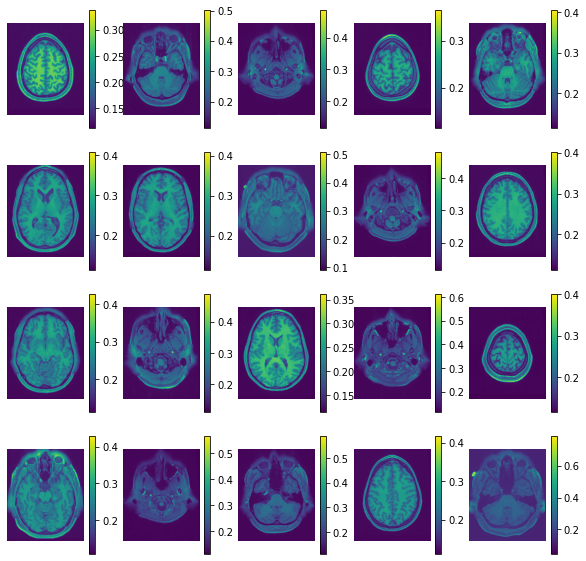

In [22]:
plot_images(batch_x[:20])

### Reconstructions baseline AE

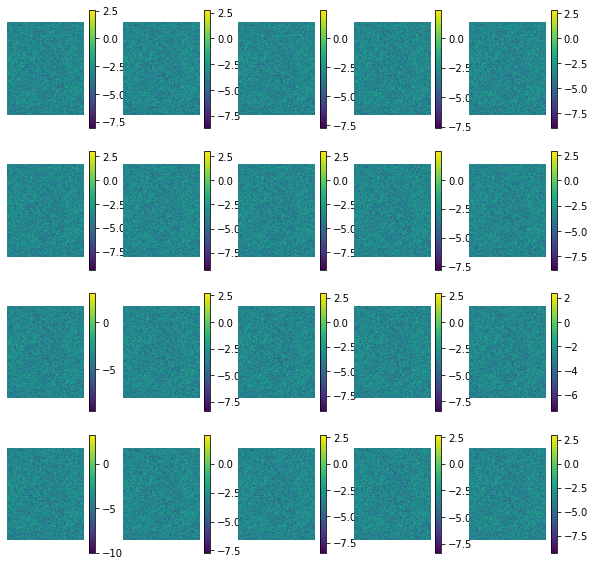

In [23]:
rec_bAE = model_base(batch_x).view(batch_x.shape)
plot_images(rec_bAE[:20])

### Reconstructions regularized AE

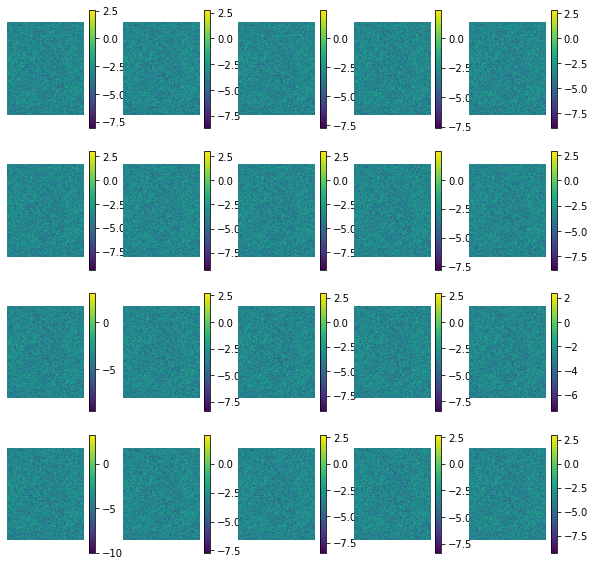

In [24]:
rec_rAE = model_reg(batch_x).view(batch_x.shape)
plot_images(rec_rAE)

## PSNR and SSIM

In [25]:
def batch_psnr(batch_prediction, batch_target):
    avg_psnr = 0
    for i in range(batch_prediction.size(0)):
        mse = F.mse_loss(batch_prediction[i], batch_target[i])
        if mse > 0.:
            psnr = 10 * torch.log10(1 / mse)
            avg_psnr += psnr
        else:
            avg_psnr += 100.

    return (avg_psnr / batch_prediction.size(0)).item()

In [37]:
psnr_rAE = batch_psnr(rec_rAE, batch_x)
psnr_bAE = batch_psnr(rec_bAE, batch_x)
print("PSNR rAE: %.2f, bAE: %.2f" % (psnr_rAE, psnr_bAE))

PSNR rAE: -11.75, bAE: -11.75


In [38]:
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM


In [39]:
ssim_val = ssim( rec_rAE, batch_x, data_range=255, size_average=False) # return (N,)
ssim_val.shape

torch.Size([200])

In [2]:
ssim_val

NameError: name 'ssim_val' is not defined

In [35]:
import torch
from piq import ssim, SSIMLoss

#x = torch.rand(4, 3, 256, 256, requires_grad=True)
#y = torch.rand(4, 3, 256, 256)

ssim_index = ssim(rec_rAE, batch_x, data_range=250.)

'''loss = SSIMLoss(data_range=1.)
output: torch.Tensor = loss(x, y)
output.backward()'''
ssim_index

AssertionError: Expected values to be greater or equal to 0, got -10.247312545776367

In [34]:
ssim_index

tensor(1.)

## Transformations

In [32]:
transform_noise = transforms.Compose([
    transforms.ColorJitter(),
    transforms.])

SyntaxError: invalid syntax (413274311.py, line 3)